# Credit Card Fraud Detection

## What is Credit Card Fraud?
Credit card fraud is when someone uses another person's credit card or account information to make unauthorized purchases or access funds through cash advances. Credit card fraud doesn’t just happen online; it happens in brick-and-mortar stores, too. As a business owner, you can avoid serious headaches – and unwanted publicity – by recognizing potentially fraudulent use of credit cards in your payment environment.

## Three challenges surrounding credit card fraud

1. It's not always easy to agree on ground truth for what "fraud" means.
2. Regardless of how you define ground truth, the vast majority of charges are not fraudulent.
3. Most merchants aren't experts at evaluating the business impact of fraud.

## Problem Statement:

The Credit Card Fraud Detection Problem includes modeling past credit card transactions with the knowledge of the ones that turned out to be a fraud. This model is then used to identify whether a new transaction is fraudulent or not. Our aim here is to detect 100% of the fraudulent transactions while minimizing the incorrect fraud classifications.

## Why does class imbalanced affect model performance?

- In general, we want to maximize the recall while capping FPR (False Positive Rate), but you can classify a lot of charges wrong and still maintain a low FPR because you have a large number of true negatives.
- This is conducive to picking a relatively low threshold, which results in the high recall but extremely low precision.

## What is the catch?
- Training a model on a balanced dataset optimizes performance on validation data.
- However, the goal is to optimize performance on the imbalanced production dataset. You ultimately need to find a balance that works best in production.
- One solution to this problem is: Use all fraudulent transactions, but subsample non-fraudulent transactions as needed to hit our target rate.

## Business questions to brainstorm:
Since all features are anonymous, we will focus our analysis on non-anonymized features: `Time`, `Amount`
1. How different is the amount of money used in different transaction classes?
2. Do fraudulent transactions occur more often during a certain frames?


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("whitegrid")

In [2]:
data = pd.read_csv("data/creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# 1. Exploratory Data Analysis


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [4]:
pd.set_option("display.float", "{:.2f}".format)
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,...,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00
mean,94813.86,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,88.35,0.00
std,47488.15,1.96,1.65,1.52,1.42,1.38,1.33,1.24,1.19,1.10,...,0.73,0.73,0.62,0.61,0.52,0.48,0.40,0.33,250.12,0.04
min,0.00,-56.41,-72.72,-48.33,-5.68,-113.74,-26.16,-43.56,-73.22,-13.43,...,-34.83,-10.93,-44.81,-2.84,-10.30,-2.60,-22.57,-15.43,0.00,0.00
25%,54201.50,-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.64,...,-0.23,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,5.60,0.00
50%,84692.00,0.02,0.07,0.18,-0.02,-0.05,-0.27,0.04,0.02,-0.05,...,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,22.00,0.00
75%,139320.50,1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,...,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,77.16,0.00
max,172792.00,2.45,22.06,9.38,16.88,34.80,73.30,120.59,20.01,15.59,...,27.20,10.50,22.53,4.58,7.52,3.52,31.61,33.85,25691.16,1.00


Let us now check the missing values in the dataset

In [5]:
data.isnull().sum().sum()

0

In [6]:
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

### The only non-transformed variables to work with are:
- `Time`
- `Amount`
- `Class` (1: fraud, 0: not_fraud)

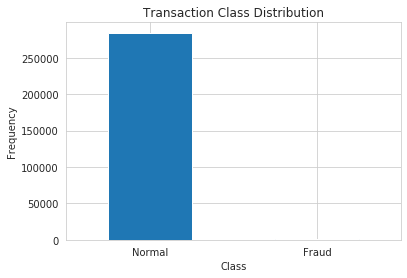

In [7]:
LABELS = ["Normal", "Fraud"]

count_classes = pd.value_counts(data['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction Class Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [8]:
data.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

Notice how imbalanced is our original dataset! Most of the transactions are non-fraud. If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most transactions are not fraud. But we don't want our model to assume, we want our model to detect patterns that give signs of fraud!

Determine the number of fraud and valid transactions in the entire dataset.

In [9]:
fraud = data[data['Class']==1]
normal = data[data['Class']==0]

In [10]:
print(f"Shape of Fraudulant transactions: {fraud.shape}")
print(f"Shape of Non-Fraudulant transactions: {normal.shape}")

Shape of Fraudulant transactions: (492, 31)
Shape of Non-Fraudulant transactions: (284315, 31)


How different are the amount of money used in different transaction classes?

In [11]:
pd.concat([fraud.Amount.describe(), normal.Amount.describe()], axis=1)

,Amount,Amount
count,492.00,284315.00
mean,122.21,88.29
std,256.68,250.11
min,0.00,0.00
25%,1.00,5.65
50%,9.25,22.00
75%,105.89,77.05
max,2125.87,25691.16


Do fraudulent transactions occur more often during certain time frame ?

In [12]:
pd.concat([fraud.Time.describe(), normal.Time.describe()], axis=1)

,Time,Time
count,492.00,284315.00
mean,80746.81,94838.20
std,47835.37,47484.02
min,406.00,0.00
25%,41241.50,54230.00
50%,75568.50,84711.00
75%,128483.00,139333.00
max,170348.00,172792.00


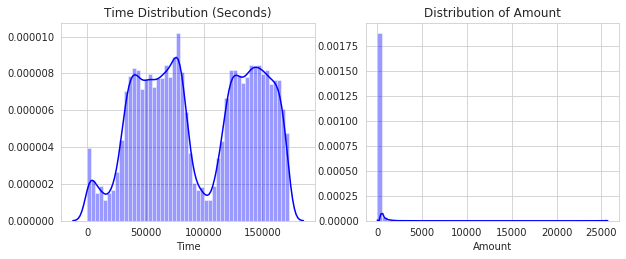

In [13]:
# plot the time feature
plt.figure(figsize=(10,8))

plt.subplot(2, 2, 1)
plt.title('Time Distribution (Seconds)')

sns.distplot(data['Time'], color='blue');

#plot the amount feature
plt.subplot(2, 2, 2)
plt.title('Distribution of Amount')
sns.distplot(data['Amount'],color='blue');

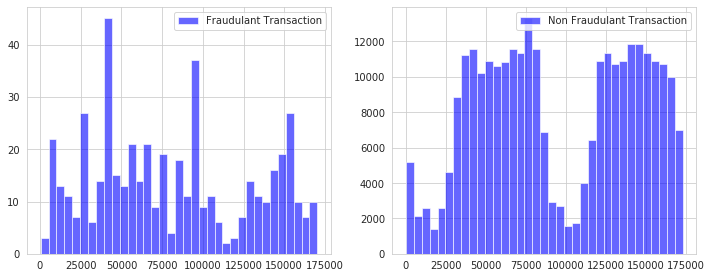

In [14]:
# data[data.Class == 0].Time.hist(bins=35, color='blue', alpha=0.6)
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
data[data.Class == 1].Time.hist(bins=35, color='blue', alpha=0.6, label="Fraudulant Transaction")
plt.legend()

plt.subplot(2, 2, 2)
data[data.Class == 0].Time.hist(bins=35, color='blue', alpha=0.6, label="Non Fraudulant Transaction")
plt.legend()

By seeing the distributions we can have an idea how skewed are these features, we can also see further distributions of the other features. There are techniques that can help the distributions be less skewed which will be implemented in this notebook in the future.

Doesn't seem like the time of transaction really matters here as per above observation.
Now let us take a sample of the dataset for out modelling and prediction

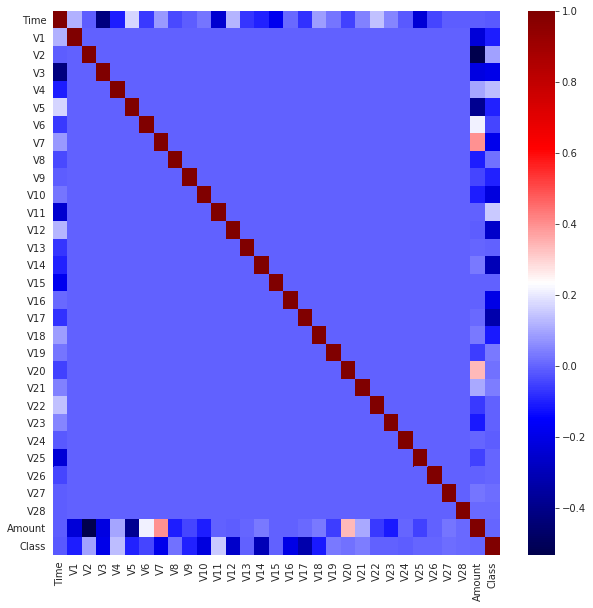

In [15]:
# heatmap to find any high correlations

plt.figure(figsize=(10,10))
sns.heatmap(data=data.corr(), cmap="seismic")
plt.show();

## Highest correlations come from:
    - Time & V3 (-0.42)
    - Amount & V2 (-0.53)
    - Amount & V4 (0.4)

- While these correlations are high, I don't expect it to run the risk of multicollinearity.

- The correlation matrix shows also that none of the V1 to V28 PCA components have any correlation to each other however if we observe Class has some form positive and negative correlations with the V components but has no correlation with Time and Amount.

## Observations
- Very few transactions are actually fraudulent (less than 1%). The data set is highly skewed, consisting of `492` frauds in a total of `284,807` observations. This resulted in only `0.172%` fraud cases. This skewed set is justified by the low number of fraudulent transactions.
- The dataset consists of numerical values from the `28` ‘`Principal Component Analysis (PCA)`’ transformed features, namely V1 to V28. Furthermore, there is no metadata about the original features provided, so pre-analysis or feature study could not be done.
- The ‘Time’ and ‘Amount’ features are not transformed data.
- There is no missing value in the dataset.

### Data Pre-processing

`Time` and `Amount` should be scaled as the other columns.

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()

X = data.drop('Class', axis=1)
y = data.Class

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)

In [19]:
print(f"TRAINING: X_train: {X_train.shape}, y_train: {y_train.shape}\n{'_'*55}")
print(f"TESTING: X_test: {X_test.shape}, y_test: {y_test.shape}")

TRAINING: X_train: (199364, 30), y_train: (199364,)
_______________________________________________________
TESTING: X_test: (85443, 30), y_test: (85443,)


In [20]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

def print_score(label, prediction, train=True):
    if train:
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(label, prediction) * 100:.4f}%")
        print("_______________________________________________")
        print("Classification Report:", end='')
        print(f"\tPrecision Score: {precision_score(label, prediction) * 100:.2f}%")
        print(f"\t\t\tRecall Score: {recall_score(label, prediction) * 100:.2f}%")
        print(f"\t\t\tF1 score: {f1_score(label, prediction) * 100:.2f}%")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, prediction)}\n")
        
    elif train==False:
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(label, prediction) * 100:.4f}%")
        print("_______________________________________________")
        print("Classification Report:", end='')
        print(f"\tPrecision Score: {precision_score(label, prediction) * 100:.2f}%")
        print(f"\t\t\tRecall Score: {recall_score(label, prediction) * 100:.2f}%")
        print(f"\t\t\tF1 score: {f1_score(label, prediction) * 100:.2f}%")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(label, prediction)}\n") 

# Model Building (Imbalanced Dataset) CNNs, XGBoost

# 1. Convolutional Neural Network (CNNs)

In [28]:
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

In [29]:
print(f"TRAINING: X_train: {X_train.shape}, y_train: {y_train.shape}\n{'_'*55}")
print(f"TESTING: X_test: {X_test.shape}, y_test: {y_test.shape}")

TRAINING: X_train: (199364, 30, 1), y_train: (199364,)
_______________________________________________________
TESTING: X_test: (85443, 30, 1), y_test: (85443,)


In [23]:
import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import TensorBoard

Using TensorFlow backend.


In [40]:
epochs = 6
model = Sequential()
model.add(Conv1D(32, 2, activation='relu', input_shape=X_train_d[0].shape))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(64, 2, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(128, 2, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))

In [41]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 29, 32)            96        
_________________________________________________________________
batch_normalization_10 (Batc (None, 29, 32)            128       
_________________________________________________________________
dropout_16 (Dropout)         (None, 29, 32)            0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 28, 64)            4160      
_________________________________________________________________
batch_normalization_11 (Batc (None, 28, 64)            256       
_________________________________________________________________
dropout_17 (Dropout)         (None, 28, 64)            0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 27, 128)          

In [42]:
# weights = {0:1, 1:5}
model.compile(optimizer=Adam(0.0001), loss='binary_crossentropy', metrics=[keras.metrics.AUC()])
r = model.fit(X_train, y_train, 
              validation_data=(X_test, y_test),
              batch_size=50, 
              epochs=epochs, 
#               class_weight=weights
             )

Train on 199364 samples, validate on 85443 samples
Epoch 1/6
199364/199364 [==============================] - 785s 4ms/step - loss: 0.0109 - auc_4: 0.8764 - val_loss: 0.0068 - val_auc_4: 0.9226
Epoch 2/6
199364/199364 [==============================] - 782s 4ms/step - loss: 0.0064 - auc_4: 0.8974 - val_loss: 0.0054 - val_auc_4: 0.9554
Epoch 3/6
199364/199364 [==============================] - 782s 4ms/step - loss: 0.0057 - auc_4: 0.9102 - val_loss: 0.0028 - val_auc_4: 0.9660
Epoch 4/6
199364/199364 [==============================] - 813s 4ms/step - loss: 0.0045 - auc_4: 0.9201 - val_loss: 0.0067 - val_auc_4: 0.9677
Epoch 5/6
199364/199364 [==============================] - 817s 4ms/step - loss: 0.0042 - auc_4: 0.9314 - val_loss: 0.0042 - val_auc_4: 0.9618
Epoch 6/6
199364/199364 [==============================] - 818s 4ms/step - loss: 0.0040 - auc_4: 0.9370 - val_loss: 0.0024 - val_auc_4: 0.9660


In [43]:
training_score = model.evaluate(X_train, y_train)
testing_score = model.evaluate(X_test, y_test)

print(f"TRAINING SCORE: {training_score}")
print(f"TESTING SCORE: {testing_score}")

85443/85443 [==============================] - 97s 1ms/step
TRAINING SCORE: [0.002216556592624332, 0.9795027375221252]
TESTING SCORE: [0.002412950420231434, 0.9659817814826965]


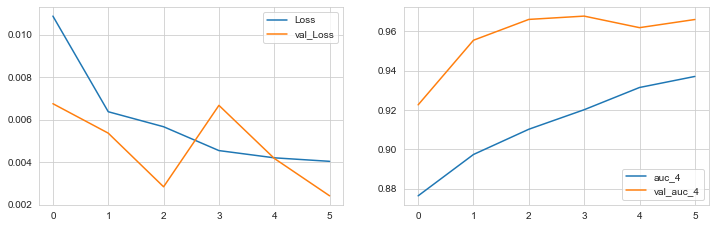

In [45]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='val_Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(r.history['auc_4'], label='auc_4')
plt.plot(r.history['val_auc_4'], label='val_auc_4')
plt.legend()

In [46]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print_score(y_train, y_train_pred.round(), train=True)
print_score(y_test, y_test_pred.round(), train=False)

Train Result:
Accuracy Score: 99.95%
_______________________________________________
Classification Report:	Precision Score: 92.31%
			Recall Score: 77.53%
			F1 score: 84.27%
_______________________________________________
Confusion Matrix: 
 [[198985     23]
 [    80    276]]

Test Result:
Accuracy Score: 99.95%
_______________________________________________
Classification Report:	Precision Score: 85.94%
			Recall Score: 80.88%
			F1 score: 83.33%
_______________________________________________
Confusion Matrix: 
 [[85289    18]
 [   26   110]]



## Adding MaxPooling

In [49]:
epochs = 50
model = Sequential()
model.add(Conv1D(32, 2, activation='relu', input_shape=X_train[0].shape))
model.add(BatchNormalization())
model.add(MaxPooling1D(2))
model.add(Dropout(0.2))

model.add(Conv1D(64, 2, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(2))
model.add(Dropout(0.2))

model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

# weights = {0:1, 1:5}
model.compile(optimizer=Adam(0.0001), loss='binary_crossentropy', metrics=[keras.metrics.AUC()])
r = model.fit(X_train, y_train, 
              validation_data=(X_test, y_test),
              batch_size=50, 
              epochs=epochs, 
#               class_weight=weights
             )

Train on 199364 samples, validate on 85443 samples
Epoch 1/50
199364/199364 [==============================] - 369s 2ms/step - loss: 0.0134 - auc_5: 0.8049 - val_loss: 0.0185 - val_auc_5: 0.9686
Epoch 2/50
199364/199364 [==============================] - 370s 2ms/step - loss: 0.0075 - auc_5: 0.8806 - val_loss: 0.0139 - val_auc_5: 0.9731
Epoch 3/50
199364/199364 [==============================] - 373s 2ms/step - loss: 0.0060 - auc_5: 0.9035 - val_loss: 0.0093 - val_auc_5: 0.9713
Epoch 4/50
199364/199364 [==============================] - 373s 2ms/step - loss: 0.0056 - auc_5: 0.9134 - val_loss: 0.0118 - val_auc_5: 0.9708
Epoch 5/50
199364/199364 [==============================] - 375s 2ms/step - loss: 0.0053 - auc_5: 0.9165 - val_loss: 0.0128 - val_auc_5: 0.9732
Epoch 6/50
199364/199364 [==============================] - 375s 2ms/step - loss: 0.0053 - auc_5: 0.9190 - val_loss: 0.0103 - val_auc_5: 0.9741
Epoch 7/50
199364/199364 [==============================] - 384s 2ms/step - loss: 0.0

In [50]:
training_score = model.evaluate(X_train, y_train)
testing_score = model.evaluate(X_test, y_test)

print(f"TRAINING SCORE: {training_score}")
print(f"TESTING SCORE: {testing_score}")

Train Result:
Accuracy Score: 99.94%
_______________________________________________
Classification Report:	Precision Score: 81.59%
			Recall Score: 83.43%
			F1 score: 82.50%
_______________________________________________
Confusion Matrix: 
 [[198941     67]
 [    59    297]]

Test Result:
Accuracy Score: 99.94%
_______________________________________________
Classification Report:	Precision Score: 79.73%
			Recall Score: 86.76%
			F1 score: 83.10%
_______________________________________________
Confusion Matrix: 
 [[85277    30]
 [   18   118]]



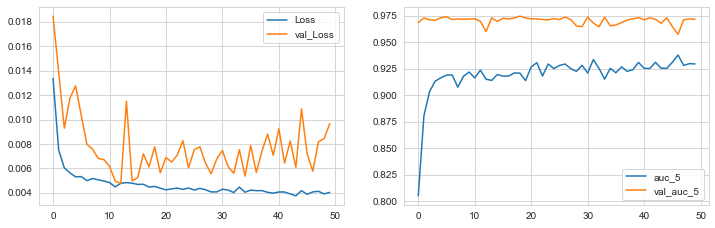

In [51]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='val_Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(r.history['auc_5'], label='auc_5')
plt.plot(r.history['val_auc_5'], label='val_auc_5')
plt.legend()

In [52]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print_score(y_train, y_train_pred.round(), train=True)
print_score(y_test, y_test_pred.round(), train=False)

Train Result:
Accuracy Score: 99.94%
_______________________________________________
Classification Report:	Precision Score: 81.59%
			Recall Score: 83.43%
			F1 score: 82.50%
_______________________________________________
Confusion Matrix: 
 [[198941     67]
 [    59    297]]

Test Result:
Accuracy Score: 99.94%
_______________________________________________
Classification Report:	Precision Score: 79.73%
			Recall Score: 86.76%
			F1 score: 83.10%
_______________________________________________
Confusion Matrix: 
 [[85277    30]
 [   18   118]]



# Model Building (Imbalanced Dataset)

In [58]:
X = data.drop('Class', axis=1)
y = data.Class

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Concatinating X_train and y_train
df = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], axis=1)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
2557,2105.00,-2.29,-0.48,0.82,-1.71,0.82,-1.66,0.94,-0.54,1.32,...,-0.21,0.91,0.87,0.42,0.31,-0.78,0.39,-0.15,1.00,0
247823,153702.00,-0.31,-4.06,-3.40,0.70,0.10,1.53,1.55,-0.04,0.02,...,0.85,-0.09,-0.94,-0.83,-0.50,0.65,-0.29,0.11,1194.28,0
152342,97283.00,-1.81,-0.57,2.27,-0.96,-1.21,1.52,-1.42,0.90,1.96,...,-0.51,-0.42,-0.27,0.01,0.47,0.84,-0.06,0.09,75.00,0
103385,68628.00,1.19,0.18,0.14,0.46,-0.05,-0.11,-0.16,0.16,-0.07,...,-0.24,-0.74,0.12,-0.37,0.13,0.13,-0.02,0.01,1.98,0
8771,11951.00,-0.96,0.70,1.10,-1.55,0.67,0.51,0.33,0.27,1.38,...,-0.28,-0.47,-0.12,-1.39,-0.24,0.79,0.35,0.22,37.31,0


In [59]:
df.shape

(199364, 31)

In [60]:
from sklearn.utils import resample

minority_class = df[df.Class == 1]
majority_class = df[df.Class == 0]

majority_downsample = resample(majority_class, replace=False, 
                               n_samples=minority_class.shape[0], 
                               random_state=42)

df_2 = pd.concat([majority_downsample, minority_class])
df_2.Class.value_counts()

1    356
0    356
Name: Class, dtype: int64

In [61]:
df_2.shape

(712, 31)

In [62]:
scaler = StandardScaler()

X = df_2.drop('Class', axis=1)
y = df_2.Class

X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.3, random_state=42)

X_train = scaler.fit_transform(X_train)
X_validate = scaler.transform(X_validate)
X_test = scaler.transform(X_test)

X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)
X_validate = np.expand_dims(X_validate, -1)

print(X_train.shape)
print(y_train.shape)
print(X_validate.shape)
print(y_validate.shape)
print(X_test.shape)
print(y_test.shape)

(498, 30, 1)
(498,)
(214, 30, 1)
(214,)
(85443, 30, 1)
(85443,)


In [63]:
epochs = 150
model = Sequential()
model.add(Conv1D(32, 2, activation='relu', input_shape=X_train[0].shape))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Conv1D(64, 2, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(128, 2, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

# weights = {0:1, 1:5}
model.compile(optimizer=Adam(0.00001), loss='binary_crossentropy', metrics=["accuracy"])
r = model.fit(X_train, y_train, 
              validation_data=(X_validate, y_validate),
              batch_size=50, 
              epochs=epochs, 
#               class_weight=weights
             )

Train on 498 samples, validate on 214 samples
Epoch 1/150
498/498 [==============================] - 4s 8ms/step - loss: 0.8512 - accuracy: 0.6386 - val_loss: 0.6802 - val_accuracy: 0.5794
Epoch 2/150
498/498 [==============================] - 3s 6ms/step - loss: 0.8330 - accuracy: 0.6386 - val_loss: 0.6651 - val_accuracy: 0.7991
Epoch 3/150
498/498 [==============================] - 3s 6ms/step - loss: 0.7429 - accuracy: 0.6767 - val_loss: 0.6506 - val_accuracy: 0.7570
Epoch 4/150
498/498 [==============================] - 3s 6ms/step - loss: 0.6428 - accuracy: 0.7229 - val_loss: 0.6372 - val_accuracy: 0.7243
Epoch 5/150
498/498 [==============================] - 2s 4ms/step - loss: 0.5597 - accuracy: 0.7590 - val_loss: 0.6246 - val_accuracy: 0.7150
Epoch 6/150
498/498 [==============================] - 2s 4ms/step - loss: 0.5447 - accuracy: 0.7811 - val_loss: 0.6117 - val_accuracy: 0.7103
Epoch 7/150
498/498 [==============================] - 2s 4ms/step - loss: 0.5636 - accuracy: 0.

In [64]:
score = model.evaluate(X_test, y_test)
print(score)

85443/85443 [==============================] - 97s 1ms/step
[0.08371787144375702, 0.9781959652900696]


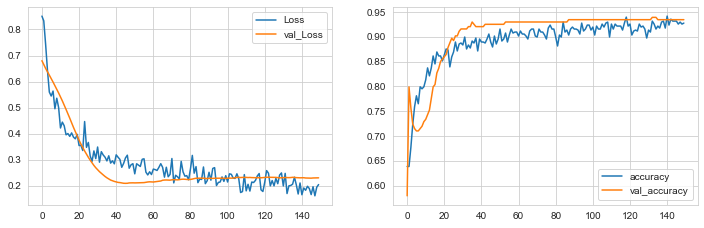

In [65]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='val_Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()

In [66]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print_score(y_train, y_train_pred.round(), train=True)
print_score(y_test, y_test_pred.round(), train=False)

Train Result:
Accuracy Score: 95.58%
_______________________________________________
Classification Report:	Precision Score: 99.18%
			Recall Score: 92.34%
			F1 score: 95.63%
_______________________________________________
Confusion Matrix: 
 [[235   2]
 [ 20 241]]

Test Result:
Accuracy Score: 97.82%
_______________________________________________
Classification Report:	Precision Score: 6.28%
			Recall Score: 91.18%
			F1 score: 11.75%
_______________________________________________
Confusion Matrix: 
 [[83456  1851]
 [   12   124]]



In [ ]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(n_estimators=500, 
                          learning_rate=0.1, 
                          base_score=0.99)
xgb_model.fit(X_train, y_train)

y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

print_score(y_train, y_train_pred.round(), train=True)
print_score(y_test, y_test_pred.round(), train=False)